# An example of fitting the synthetic nascent signal data

In [1]:
using CSV, DataFrames
using Plots; theme(:vibrant)
using RNAInferenceTool, StatsBase

## Import data and load SSA functions

In [2]:
# Import SSA code install delay SSA package at https://github.com/palmtree2013/DelaySSAToolkit.jl
include("delaytelegraphSSA.jl")
# Parameters 
τ = 0.5
tf = 20 
params = [1.0526,8.2034,57.989,0,0,τ,tf] # σ_off, σ_on, ρ_on, ρ_off, d, τ, SSA final time
L1 = 862; L = 3062; # L1 =  signal fluorescence 862 bp; L = total gene 3062 bp 

3062

## Generate synthetic SSA signal data

In [3]:
numofRun = 10000 # delay SSA sample size
djprob = construct_prob_delaytelegraph(params)
ens_prob = EnsembleProblem(djprob)
ens = solve(ens_prob, SSAStepper(), EnsembleThreads(), trajectories = numofRun);

## Check the distribution

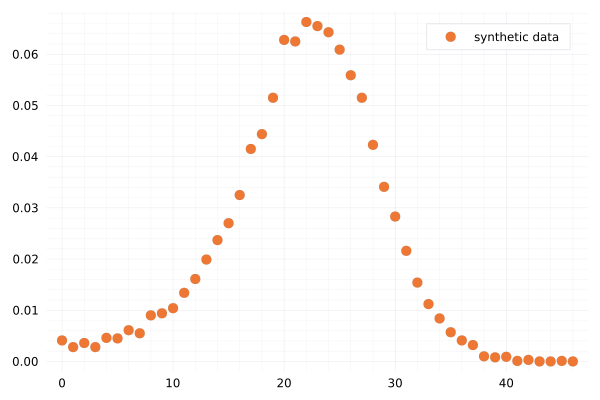

In [4]:
filter_pos_tf = [ens[i].channel[end][1] for i in eachindex(ens)]
res_ens = [signal_function.(filter_pos_tf[i], τ = τ, L1 = L1, L = L) for i in eachindex(filter_pos_tf)]
histo_synthetic = sum_with_non.(res_ens)
scatter(convert_histo(histo_synthetic), labels="synthetic data") # plot distribution

 # Inference

## load functions and set parameters

In [5]:
#For delay model the parameter order: σ_off, σ_on, ρ_on, ρ_off, d, τ
SRange = [(0.0,50.0),(0.0,50.0),(0.0,100.0),(0.0,0.0),(0.0,0.0),(τ,τ)];

#For telegraph model the parameter order: σ_off, σ_on, ρ_on, ρ_off, d
SRange_tele = [(0.0,50.0),(0.0,50.0),(0.0,100.0),(0.0,0.0),(1/τ,1/τ)];

The `OptimStruct` consists of four elements:
1. data: default type is histogram data; the other supported type is to use distribution directly;
2. stage: G1 or G2; where G2 type data is inferred by setting G2 = G1*G1 (convolution);
3. dist: the distance function: Likelihood, Likelihood_fusion, Likelihood_rejection and other distance functions in Distances.jl are supported;
4. model: telegraph model, delay telegraph model, bursty model and Poisson model are supported;
5. infer_counts: `true` if the inferred histogram data represents the number of count of the product (mature or bound Pol II), `false` if the histogram data represents the normalised signal insensity.
6. L1, L2: if infer_counts is set `false` then L1 and L2 must be provided which represents the indices of the trapezoid signal function;

In [6]:
infer_struct = OptimStruct(histo_synthetic, G1(), Likelihood(), Delay(); infer_counts = false, L1 = 862, L2 =2200)
infer_struct_tele = OptimStruct(histo_synthetic, G1(), Likelihood(), Telegraph(); infer_counts = true)

OptimStruct{G1, Likelihood, Telegraph, Nothing}([16.187943510888417, 24.98469924382512, 30.656849867828328, 24.647771135358976, 13.296172883740708, 22.828366736821668, 17.918489867957042, 19.067615255771273, 22.582387688566563, 26.09352180965069  …  10.988137653605703, 22.31172297621861, 17.1435086563177, 25.36801271481724, 24.55084718811193, 11.527032344392726, 14.0, 27.641520221637165, 26.929506708880336, 26.276911041410536], G1(), Likelihood(), Telegraph(), true, true, nothing, nothing)

In [7]:
estimated_params, distributions = optim_function(SRange, infer_struct, MaxFuncEvals = 10000)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 166 evals, 99 steps, improv/step: 0.404 (last = 0.4040), fitness=33532.567144368
1.04 secs, 346 evals, 265 steps, improv/step: 0.355 (last = 0.3253), fitness=33438.694731537
1.57 secs, 551 evals, 481 steps, improv/step: 0.318 (last = 0.2731), fitness=33426.160447752
2.08 secs, 773 evals, 725 steps, improv/step: 0.281 (last = 0.2090), fitness=33390.128355950
2.58 secs, 964 evals, 941 steps, improv/step: 0.261 (last = 0.1944), fitness=33219.747514780
3.08 secs, 1185 evals, 1185 steps, improv/step: 0.242 (last = 0.1680), fitness=33112.307261045
3.58 secs, 1404 evals, 1440 steps, improv/step: 0.226 (last = 0.1490), fitness=33011.398909027
4.08 secs, 1613 evals, 1686 steps, improv/step: 0.212 (last = 0.1301), f

([0.9286807963681223, 7.163611758048494, 57.915468169106695, 0.0, 0.0, 0.5, 32898.83596813052], [0.004898780812225544 0.0041; 0.0021208779076833475 0.0028; … ; 1.0950768619506842e-9 0.0; 4.825769757822857e-11 0.0])

In [8]:
estimated_params_tele, distributions_tele = optim_function(SRange_tele, infer_struct_tele, MaxFuncEvals = 10000)

In [ ]:
scatter(distributions[:,2],labels="synthetic data")
plot!([distributions[:,1] distributions_tele[:,1]],lines=(2, :dash),labels=["Delay Telegraph" "Telegraph"])

In [ ]:
#Compare the paramters
DataFrame(True = params[1:3],Delay=estimated_params[1:3],Telegraph= estimated_params_tele[1:3])